<a href="https://colab.research.google.com/github/YT100100/BluetoothDecoder/blob/master/20200605_StudentExperiment_ImageProcessing_OneImageTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像解析

　今回の学生実験ではpythonを使った画像解析を行います。どのようなデータを用いて行うかは岩田先生から説明があったと思いますが、ドローンで撮影したダイズの画像データを用いて行います。

　解析環境はこのGoogle ColabとR studio Cloudを用いて行います。Google Colab上ではpythonを動かして解析を行います。pythonを使ったことがない人も、そうでない人も本実験では一通りの解析フローを理解してもらえるようにコードなどを記載しているつもりです。一方で、分からないこと、疑問点が出てきた場合は（実験時間も限られているので）あまり悩まず気軽にTAや先生に聞いてください。

## パッケージの読み込み

　まずはじめに、本解析で使うパッケージの読み込みを行います。Rではrequire()で読み込んでいましたが、pythonではimportを用いて読み込みます。


In [0]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage import filters
from google.colab import files
import pandas as pd
from PIL import Image
from IPython.display import display
from sklearn.cluster import KMeans

　今回使用するパッケージについて簡単に説明します。```NumPy```は数値計算ライブラリ、Matplotlibはグラフ描画ライブラリ、OpenCV・scikit-imageは画像解析、処理ライブラリ、Pandasはデータ分析ライブラリとなっています。 ##### PIL, ipython, scikit-learn #####

　これらを使う場合、```import パッケージ名 as つけたい名前``` という形で読み込みを行います。as以下は任意です。これらライブラリを用いるときに、numpy.sum()のような形で呼び出すため、利用頻度が高く長い呼称のものは別の名前に置き換えることがあります。

　またfrom パッケージ名 import モジュール名 as つけたい名前(as以下は任意)という形で読み込むことがあります。これはパッケージ全体を呼び出すのではなく、使いたいモジュールだけを読み込んでおくというものです。これはコードを書く際に短くすむというメリットや、パッケージ全体を読み込まないことで実行負荷を減らすという狙いがあります。

## RGB画像の読み込み

まずは、Google Driveから、画像ファイルをダウンロードする。gdownコマンドを使う。なお、google colabにおいて、linuxのコマンドラインを実行するには、先頭に!（エクスクラメーションマーク）をつけて、コマンドを通常通り入力する。なお、gdownコマンドがインストールされていない場合は、 pip install gdown と入力してインストールを行う。

In [2]:
!gdown --id 1H0KfaOvpEuJdSPHkJN-IJMVzAKM3f-DN

Downloading...
From: https://drive.google.com/uc?id=1H0KfaOvpEuJdSPHkJN-IJMVzAKM3f-DN
To: /content/img.zip
114MB [00:00, 221MB/s] 


次に、ダウンロードしたファイルを解凍する。unzipコマンドを用いる。-qというオプションを付けるため何も表示されないが、imgというディレクトリ（フォルダ）が作成され、画像ファイルが解凍される。ここでは、解凍後に、img.zipファイルを削除して片付けておく。

In [0]:
!unzip -q img.zip
!rm img.zip

ファイルが無事解凍されているか、lsコマンドを用いて確認する。

In [4]:
!ls -R img

img:
dsm  rgb

img/dsm:
801  810  818  825

img/dsm/801:
GmJMC021-C1.tif  GmJMC082-D1.tif  GmWMC084-C1.tif  GmWMC146-D1.tif
GmJMC021-C2.tif  GmJMC082-D2.tif  GmWMC084-C2.tif  GmWMC146-D2.tif
GmJMC021-D1.tif  GmJMC112-C1.tif  GmWMC084-D1.tif  GmWMC157-C1.tif
GmJMC021-D2.tif  GmJMC112-C2.tif  GmWMC084-D2.tif  GmWMC157-C2.tif
GmJMC025-C1.tif  GmJMC112-D1.tif  GmWMC115-C1.tif  GmWMC157-D1.tif
GmJMC025-C2.tif  GmJMC112-D2.tif  GmWMC115-C2.tif  GmWMC157-D2.tif
GmJMC025-D1.tif  GmJMC161-C1.tif  GmWMC115-D1.tif  GmWMC175-C1.tif
GmJMC025-D2.tif  GmJMC161-C2.tif  GmWMC115-D2.tif  GmWMC175-C2.tif
GmJMC082-C1.tif  GmJMC161-D1.tif  GmWMC146-C1.tif  GmWMC175-D1.tif
GmJMC082-C2.tif  GmJMC161-D2.tif  GmWMC146-C2.tif  GmWMC175-D2.tif

img/dsm/810:
GmJMC021-C1.tif  GmJMC082-D1.tif  GmWMC084-C1.tif  GmWMC146-D1.tif
GmJMC021-C2.tif  GmJMC082-D2.tif  GmWMC084-C2.tif  GmWMC146-D2.tif
GmJMC021-D1.tif  GmJMC112-C1.tif  GmWMC084-D1.tif  GmWMC157-C1.tif
GmJMC021-D2.tif  GmJMC112-C2.tif  GmWMC084-D2.tif  GmWMC15

##OpenCVでのRGB画像の読み込み

　OpenCVを用いて画像を読み込む場合、cv2.imread()という関数を用います。cv2.imreadの使い方は以下の通りです。

　cv2.imread(画像の場所・名前)

　下ではimg_origに読み込んだ画像を格納しています。その先、cv2.cvtColorではBGRとして読み込まれた画像をRGBに変換しています。OpenCVでは画像を読み込んだ時にRGBではなくBGRで読み込みます。そのため、Matplotlibなどで確認するときに変換しておかなければ、何かがおかしい画像を見ることになります。

　読み込んだ画像を確認したいときは、plt.imshow(格納したもの)で確認できます。

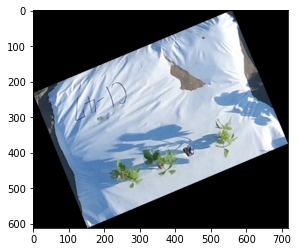

In [5]:
file_name_rgb = 'img/rgb/801/GmJMC021-C1.tif'
img_orig = cv2.imread(file_name_rgb)
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

##OpenCVでのDSM画像の読み込み

(612, 717)


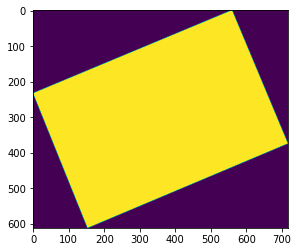

In [6]:
file_name_dsm = 'img/dsm/801/GmJMC021-C1.tif'
dsm = cv2.imread(file_name_dsm, cv2.IMREAD_UNCHANGED)
print(dsm.shape)
plt.imshow(dsm)

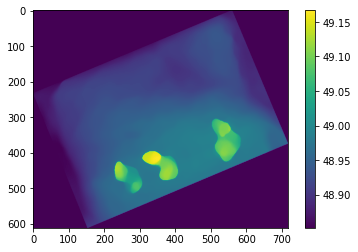

In [8]:
# ヒートマップで描画
def heatmap_dsm(dsm):
    minval_dsm = np.min(dsm[dsm > -10000])
    dsm_heatmap = dsm.copy()
    dsm_heatmap[dsm == -10000] = minval_dsm
    plt.imshow(dsm_heatmap)
    plt.colorbar()

heatmap_dsm(dsm)

## 画像について眺めてみる

　それでは読み込まれた画像はどのようなデータでしょうか？大きさなどを確認してみましょう。

　これは、.shapeで確認できます。

　この結果からわかるように、695 * 608というサイズの3次元行列に格納されていることが分かります。

　この行列の最小値と最大値はどのような値でしょうか。これはNumPyのnp.min()とnp.max()で調べることができます。それぞれ0、255ということで画像は0～255の値を持った3次元行列で表されるということがわかります

In [9]:
print(img.shape)
print(np.min(img))
print(np.max(img))

(612, 717, 3)
0
255


In [10]:
print(dsm.shape)
print(np.min(dsm))
print(np.max(dsm))

(612, 717)
-10000.0
49.16675


## Greenの色による二値化

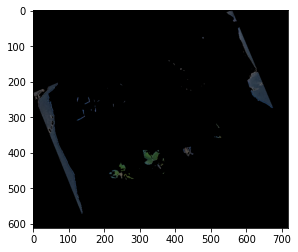

In [11]:
def segmentation_green(img, th):
    # 輝度値に変換
    img_green = img[:, :, 1]

    # 閾値以上の値を0にする
    img_seg = img.copy()
    for i in range(3):
        img_seg[:, :, i][img_green > th] = 0
    return img_seg

# 緑の値が100以下のピクセルを抜き出すと
img_seg_green = segmentation_green(img, 100)
plt.imshow(img_seg_green)

## 輝度による二値化

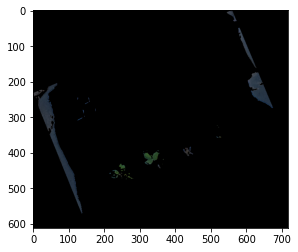

In [13]:
def segmentation_grayscale(img, th):
    # 輝度値に変換
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # opencvを使わないで計算するなら
    # 輝度値は通常 R * 0.299 + G * 0.587 + B * 0.114 で計算されるので
    # im_gray = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114 
    # とすればよい

    # 閾値以上の値を0にする
    th, img_bin = cv2.threshold(img_gray, th, 255, cv2.THRESH_BINARY_INV)
    img_seg = img.copy()
    for i in range(3):
        img_seg[:, :, i][img_bin == 0] = 0
    return img_seg

# 輝度値が80以下のピクセルを抜き出すと
img_seg_grayscale = segmentation_grayscale(img, 80)
plt.imshow(img_seg_grayscale)

## GRVI による二値化

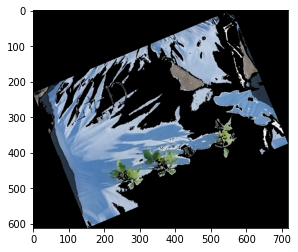

In [14]:
def segmentation_grvi(img, th):
    # GRVIを計算
    img_ones = np.ones(img.shape[:2])
    img_grvi_n = (img[:, :, 1] - img[:, :, 0])
    img_grvi_d = (img[:, :, 1] + img[:, :, 0] + img_ones)
    img_grvi = img_grvi_n / img_grvi_d

    # 閾値以下の値を0にする
    img_seg = img.copy()
    for i in range(3):
        img_seg[:, :, i][img_grvi < th] = 0
    return img_seg

# GRVI < 0.4 のピクセルを抜き出す
img_seg_grvi = segmentation_grvi(img, 0.1)
plt.imshow(img_seg_grvi)

## Hueによる二値化

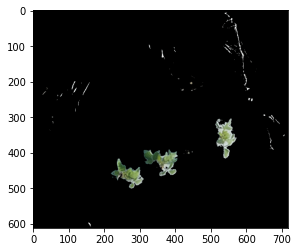

In [15]:
def segmentation_hue(img, th_lower, th_upper):
    # HSV色空間による表現に変換
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Hueの上限と下限を超えた値を０にする
    img_seg = img.copy()
    for i in range(3):
        img_seg[:, :, i][img_hsv[:, :, 0] > th_upper] = 0
        img_seg[:, :, i][img_hsv[:, :, 0] < th_lower] = 0
    return img_seg

# 輝度値が80以下のピクセルを抜き出すと
img_seg_hue = segmentation_hue(img, 20, 90)
plt.imshow(img_seg_hue)

##２つの画像で、両方とも残ったピクセルだけ抜き出す
ここでは 輝度値
 と Hue の両方の条件を生き残ったものを抜き出す

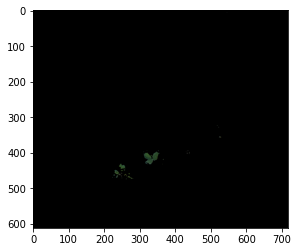

In [16]:
def extract_duplicated_pixels(img1, img2):
    # 二つの画像のどちらでも黒くなっていない部分を指定する
    img1_sum = np.sum(img1, axis=2)
    img2_sum = np.sum(img2, axis=2)
    img_duplicated = (img1_sum > 0) & (img2_sum > 0)

    # 指定された部分を抜き出す
    img_seg = img1.copy()
    for i in range(3):
        img_seg[:, :, i][img_duplicated == False] = 0
    return img_seg

# 輝度 と Hue の両方の条件を生き残ったピクセルを抜き出す
img_seg_grayscale_hue = extract_duplicated_pixels(img_seg_grayscale, img_seg_hue)
plt.imshow(img_seg_grayscale_hue)

## 植物体の部分の色情報をベクトルに直す

(1225, 3)


(array([[  0.,  13., 151., 515., 431.,  92.,  23.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   5.,   3.,  74., 414., 540., 189.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   3., 184., 614., 253., 121.,  50.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <a list of 3 Lists of Patches objects>)

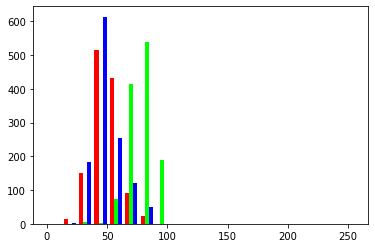

In [17]:
img_seg_colorsum = np.sum(img_seg_grayscale_hue, axis=2)
leafcol = img_seg_grayscale_hue[img_seg_colorsum > 0]
print(leafcol.shape)
plt.hist(leafcol, bins=20, range=(0, 255), 
         color = [(1, 0, 0), (0, 1, 0), (0, 0, 1)])

## 植被面積を計算する

In [18]:
def calculate_canopy_area(img_seg, file_name):
    # 1ピクセルが何m2にあたるか
    # 日付と処理区ごとに異なる
    # 日付：8/1, 8/10, 8/18, 8/25
    # 処理区：C, D
    area_per_pixel= {
        "801_C":0.0000052441, "801_D":0.0000073441, 
        "810_C":0.0000073984, "810_D":0.0000082369, 
        "818_C":0.0000069696, "818_D":0.0000096100, 
        "825_C":0.0000072361, "825_D":0.0000075625
    }
    
    # 日付と処理区を取得
    date = file_name.split('/')[2]
    treatment = file_name.split('/')[3][-6]
    key = date + '_' + treatment

    # 画像の黒くない部分のピクセル数を数える
    img_plant = (np.sum(img_seg, axis=2) != 0)
    n_pixel = np.sum(img_plant)

    # ピクセル数を面積に変換
    canopy_area = n_pixel * area_per_pixel[key]
    return canopy_area

# 植被面積を計算
canopy_area = calculate_canopy_area(img_seg_grayscale_hue, file_name_rgb)
print(str(round(canopy_area, 3)) + ' m^2')

0.006 m^2


## 草丈を計算する

In [19]:
def calculate_canopy_height(img_seg, dsm):
    # 植物の部分 = 画像の黒くない部分を指定する
    img_plant = (np.sum(img_seg, axis=2) != 0)

    # プロットの外の部分を指定する
    img_plot = (dsm != -10000)

    # 植物の部分とそれ以外の部分の高さを取ってくる
    elevation_plant    = dsm[img_plant]
    elevation_nonplant = dsm[np.logical_not(img_plant) & img_plot]

    # 植物の部分の最大値 - それ以外の部分の平均値
    elevation_plant_max = np.max(elevation_plant)
    elevation_nonplant_mean = np.mean(elevation_nonplant)
    canopy_height = elevation_plant_max - elevation_nonplant_mean
    return canopy_height

# 草丈を計算
canopy_height = calculate_canopy_height(img_seg_grayscale_hue, dsm)
print(str(round(canopy_height, 3)) + ' m')

0.225 m


## 体積を計算する

In [20]:
def calculate_canopy_volume(img_seg, dsm, file_name):
    # 1ピクセルが何m2にあたるか
    # 日付と処理区ごとに異なる
    # 日付：8/1, 8/10, 8/18, 8/25
    # 処理区：C, D
    area_per_pixel= {
        "801_C":0.0000052441, "801_D":0.0000073441, 
        "810_C":0.0000073984, "810_D":0.0000082369, 
        "818_C":0.0000069696, "818_D":0.0000096100, 
        "825_C":0.0000072361, "825_D":0.0000075625
    }
    
    # 日付と処理区を取得
    date = file_name.split('/')[2]
    treatment = file_name.split('/')[3][-6]
    key = date + '_' + treatment

    # 植物の部分 = 画像の黒くない部分を指定する
    img_plant = (np.sum(img_seg, axis=2) != 0)

    # プロットの外の部分を指定する
    img_plot = (dsm != -10000)

    # 植物の部分とそれ以外の部分の高さを取ってくる
    elevation_plant    = dsm[img_plant]
    elevation_nonplant = dsm[np.logical_not(img_plant) & img_plot]

    # 植物の部分 - それ以外の部分の平均値
    elevation_nonplant_mean = np.mean(elevation_nonplant)
    canopy_pixel_height = elevation_plant - elevation_nonplant_mean

    # 植物の高さを全部足し、体積に換算
    canopy_volume = np.sum(canopy_pixel_height) * area_per_pixel[key]
    return canopy_volume

# 草丈を計算
canopy_volume = calculate_canopy_volume(img_seg_grayscale_hue, dsm, file_name_rgb)
print(str(round(canopy_volume, 5)) + ' m3')

0.00118 m3


## 代表色の可視化

### 中央値・平均値による代表色の可視化

median color:


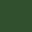

average color:


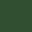

In [21]:
#画像の中の色の中央値
"""
パラメタ：
col_im：対象画像
"""
def maincol_med(col_im):
  if len(leafcol) == 0:
      return 0
  else:
    medcol = np.median(leafcol, axis=0)

    rgb_arr = medcol.astype(int, copy=False)
    color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
    color_img = Image.new(mode='RGB', size=(32, 32), color=color_hex_str)
    print("median color:")
    display(color_img)

#画像の中の色の平均値
"""
パラメタ：
col_im：対象画像
"""

def maincol_ave(col_im):
  if len(leafcol) == 0:
      return 0
  else:
    sumcol = np.sum(leafcol, axis=0)
    avecol = sumcol/len(leafcol)

    rgb_arr = avecol.astype(int, copy=False)
    color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
    color_img = Image.new(mode='RGB', size=(32, 32), color=color_hex_str)
    print("average color:")
    display(color_img)

maincol_med(leafcol) #中央値色の可視化
maincol_ave(leafcol) #平均値色の可視化

### K-means法による代表色の可視化

K-means colors:


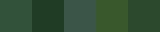

In [22]:
#K-means法で色のクラスタリング
"""
パラメタ：
col_im：対象画像
 n_cul：クラスター数
"""

def maincol_kmean(col_im, n_cul=5):
  cluster = KMeans(n_clusters=n_cul)
  cluster.fit(X=col_im)
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
      n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
      random_state=None, tol=0.0001, verbose=0)
  cluster.cluster_centers_
  cluster_centers_arr = cluster.cluster_centers_.astype(int, copy=False)

  IMG_SIZE = 32
  MARGIN = 0
  width = IMG_SIZE *  n_cul + MARGIN * 2
  height = IMG_SIZE + MARGIN * 2
  tiled_color_img = Image.new(mode='RGB', size=(width, height), color='#333333')

  for i, rgb_arr in enumerate(cluster_centers_arr):
      color_hex_str = '#%02x%02x%02x' % tuple(rgb_arr)
      color_img = Image.new(mode='RGB', size=(IMG_SIZE, IMG_SIZE), color=color_hex_str)
      tiled_color_img.paste(im=color_img, box=(MARGIN + IMG_SIZE * i, MARGIN))
  print("K-means colors:")
  display(tiled_color_img)

maincol_kmean(leafcol, n_cul = 5) # 可視化

## 色情報の要約統計量（平均、最頻値）

In [36]:
def summarize_color(leafcol):
    # 空のデータフレームを準備
    colname1 = np.repeat(['R', 'G', 'B'], [2] * 3, axis=0)
    colname2 = ['mean', 'mode'] * 3
    colname = [colname1[i] + '_' + colname2[i] for i in range(6)]
    alldata = pd.DataFrame([[0] * 6], columns=colname)

    # R, G, B の平均値と最頻値を計算・保存
    for i in range(3):
        layer_mean = np.mean(leafcol[:, i])
        layer_count = np.bincount(leafcol[:, i])
        layer_mode = np.argmax(layer_count)
        alldata.iloc[0, i * 2] = layer_mean
        alldata.iloc[0, i * 2 + 1] = layer_mode
    return alldata

color_dataframe = summarize_color(leafcol)
color_dataframe

,R_mean,R_mode,G_mean,G_mode,B_mean,B_mode
0,49.437551,40,79.026939,87,49.346939,44


## CSVへの出力（暫定）

一応RGBの画素値も出力させています。
ただ、複数枚の処理になったときに使えるかは……？

In [0]:
def for_dataframe(area, height, volume, leaf, name_data, name_col):
    Data = pd.DataFrame()
    Data1 = pd.Series([area, height, volume], index = ["Area", "Height", "Volume"], name = file_name_rgb)
    Data = Data.append(Data1)
    Data.to_csv(name_data)
    
    dataR = pd.Series(leaf[:,0], name = "R")
    dataG = pd.Series(leaf[:,1], name = "G")
    dataB = pd.Series(leaf[:,2], name = "B")
    
    data_col = pd.concat([dataR, dataG, dataB], axis = 1)
    
    data_col.to_csv(name_col)

## 植被面積、草丈、体積
name_data = "test_student_exp_data.csv"
## RGBの画素値
name_col = "test_student_exp_col.csv"
for_dataframe(canopy_area, canopy_height, canopy_volume, leafcol, name_data, name_col)

## CSV出力

もし上で出力時点でDataFrameにしてしまうなら、こっちも書き換える

In [0]:
def output_csv(area, height, volume,
               R_mean, R_mode, G_mean, G_mode, B_mean, B_mode, 
               H_mean, H_mode, S_mean, S_mode, V_mean, V_mode,
               data_name, col_data_name):
    Data = pd.DataFrame()
    Data1 = pd.Series([area, height, volume], index = ["Area", "Height", "Volume"], name = file_name_rgb)
    Data = Data.append(Data1)
    print(Data)
    
    col_Data = pd.DataFrame()
    Data2 = pd.Series([R_mean, R_mode, G_mean, G_mode, B_mean, B_mode, 
                       H_mean, H_mode, S_mean, S_mode, V_mean, V_mode],
                      index = ["R_mean", "R_mode", "G_mean", "G_mode", "B_mean", "B_mode", 
                               "H_mean", "H_mode", "S_mean", "S_mode", "V_mean", "V_mode"],
                      name = file_name_rgb)
    col_Data = col_Data.append(Data2)
    print(col_Data)
    
    Data.to_csv(data_name)
    col_Data.to_csv(col_data_name)
    
data_name = "test_student_ex.csv"
col_data_name = "test_student_ex_col.csv"

output_csv(canopy_area, canopy_height, canopy_volume,
           R_mean, R_mode, G_mean, G_mode, B_mean, B_mode,
           H_mean, H_mode, S_mean, S_mode, V_mean, V_mode,
           data_name, col_data_name)
